**Color Correction Matrix (CCM)**

Implementation depends on opencv and numpy.

Calibrating an image using CCM, Algorithm 1:

1. Convert the image from BGR space to linear RGB space.
2. Select the area from the target colorchecker and compute the average pixel values. (targetVal)
3. Create an array containing the reference values of the target colorchecker space. (refVal)
4. Perform color fitting from colorVal to refVal to obtain color correction matrix (CCM):
-- Perform a first order color fit from targetVal to refVal. The resulting color fit matrix is obtained using multiple linear regression
5. Apply the CCM to the target image to see the calibrated image.

source: https://stackoverflow.com/questions/49221892/color-correction-matrix-in-lab-color-space-opencv

Python colormaps ref:
http://pydoc.net/pwkit/0.8.15/pwkit.colormaps/

In [64]:
import os
import numpy as np
import cv2 
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors
from matplotlib.colors import hsv_to_rgb
import import_ipynb
import colorMapper as cm

In [65]:
#Define the reference RGB values
refRGB = np.array([[115, 82, 69],[204, 161, 141], [101, 134, 179], [89, 109, 61], [141, 137, 194], [132, 228, 208],
          [249, 118, 35], [80, 91, 182], [222, 91, 125], [91, 63, 123], [173, 232, 91], [255, 164, 26],
          [44, 56, 142], [74, 148, 81], [179, 42, 50], [250, 226, 21], [191, 81, 160], [6, 142, 172],
          [252,252,252], [230,230,230], [200,200,200],[143,143,142], [100,100,100],[50,50,50]])

print(refRGB.shape)

(24, 3)


In [66]:
#cm.test_color_conversions()

flags = [i for i in dir(cv2) if i.startswith('COLOR_')]
print(flags)

['COLOR_BAYER_BG2BGR', 'COLOR_BAYER_BG2BGRA', 'COLOR_BAYER_BG2BGR_EA', 'COLOR_BAYER_BG2BGR_VNG', 'COLOR_BAYER_BG2GRAY', 'COLOR_BAYER_BG2RGB', 'COLOR_BAYER_BG2RGBA', 'COLOR_BAYER_BG2RGB_EA', 'COLOR_BAYER_BG2RGB_VNG', 'COLOR_BAYER_GB2BGR', 'COLOR_BAYER_GB2BGRA', 'COLOR_BAYER_GB2BGR_EA', 'COLOR_BAYER_GB2BGR_VNG', 'COLOR_BAYER_GB2GRAY', 'COLOR_BAYER_GB2RGB', 'COLOR_BAYER_GB2RGBA', 'COLOR_BAYER_GB2RGB_EA', 'COLOR_BAYER_GB2RGB_VNG', 'COLOR_BAYER_GR2BGR', 'COLOR_BAYER_GR2BGRA', 'COLOR_BAYER_GR2BGR_EA', 'COLOR_BAYER_GR2BGR_VNG', 'COLOR_BAYER_GR2GRAY', 'COLOR_BAYER_GR2RGB', 'COLOR_BAYER_GR2RGBA', 'COLOR_BAYER_GR2RGB_EA', 'COLOR_BAYER_GR2RGB_VNG', 'COLOR_BAYER_RG2BGR', 'COLOR_BAYER_RG2BGRA', 'COLOR_BAYER_RG2BGR_EA', 'COLOR_BAYER_RG2BGR_VNG', 'COLOR_BAYER_RG2GRAY', 'COLOR_BAYER_RG2RGB', 'COLOR_BAYER_RG2RGBA', 'COLOR_BAYER_RG2RGB_EA', 'COLOR_BAYER_RG2RGB_VNG', 'COLOR_BGR2BGR555', 'COLOR_BGR2BGR565', 'COLOR_BGR2BGRA', 'COLOR_BGR2GRAY', 'COLOR_BGR2HLS', 'COLOR_BGR2HLS_FULL', 'COLOR_BGR2HSV', 'COLOR_

In [67]:
'''
This function allows the user to select multiple color ROIs and return the comparison
image to the palette
'''
def CIEDE2000(Lab_1, Lab_2):
    '''Calculates CIEDE2000 color distance between two CIE L*a*b* colors'''
    C_25_7 = 6103515625 # 25**7
    
    L1, a1, b1 = Lab_1[0], Lab_1[1], Lab_1[2]
    L2, a2, b2 = Lab_2[0], Lab_2[1], Lab_2[2]
    C1 = math.sqrt(a1**2 + b1**2)
    C2 = math.sqrt(a2**2 + b2**2)
    C_ave = (C1 + C2) / 2
    G = 0.5 * (1 - math.sqrt(C_ave**7 / (C_ave**7 + C_25_7)))
    
    L1_, L2_ = L1, L2
    a1_, a2_ = (1 + G) * a1, (1 + G) * a2
    b1_, b2_ = b1, b2
    
    C1_ = math.sqrt(a1_**2 + b1_**2)
    C2_ = math.sqrt(a2_**2 + b2_**2)
    
    if b1_ == 0 and a1_ == 0: h1_ = 0
    elif a1_ >= 0: h1_ = math.atan2(b1_, a1_)
    else: h1_ = math.atan2(b1_, a1_) + 2 * math.pi
    
    if b2_ == 0 and a2_ == 0: h2_ = 0
    elif a2_ >= 0: h2_ = math.atan2(b2_, a2_)
    else: h2_ = math.atan2(b2_, a2_) + 2 * math.pi

    dL_ = L2_ - L1_
    dC_ = C2_ - C1_    
    dh_ = h2_ - h1_
    if C1_ * C2_ == 0: dh_ = 0
    elif dh_ > math.pi: dh_ -= 2 * math.pi
    elif dh_ < -math.pi: dh_ += 2 * math.pi        
    dH_ = 2 * math.sqrt(C1_ * C2_) * math.sin(dh_ / 2)
    
    L_ave = (L1_ + L2_) / 2
    C_ave = (C1_ + C2_) / 2
    
    _dh = abs(h1_ - h2_)
    _sh = h1_ + h2_
    C1C2 = C1_ * C2_
    
    if _dh <= math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2
    elif _dh  > math.pi and _sh < 2 * math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2 + math.pi
    elif _dh  > math.pi and _sh >= 2 * math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2 - math.pi 
    else: h_ave = h1_ + h2_
    
    T = 1 - 0.17 * math.cos(h_ave - math.pi / 6) + 0.24 * math.cos(2 * h_ave) + 0.32 * math.cos(3 * h_ave + math.pi / 30) - 0.2 * math.cos(4 * h_ave - 63 * math.pi / 180)
    
    h_ave_deg = h_ave * 180 / math.pi
    if h_ave_deg < 0: h_ave_deg += 360
    elif h_ave_deg > 360: h_ave_deg -= 360
    dTheta = 30 * math.exp(-(((h_ave_deg - 275) / 25)**2))
    
    R_C = 2 * math.sqrt(C_ave**7 / (C_ave**7 + C_25_7))  
    S_C = 1 + 0.045 * C_ave
    S_H = 1 + 0.015 * C_ave * T
    
    Lm50s = (L_ave - 50)**2
    S_L = 1 + 0.015 * Lm50s / math.sqrt(20 + Lm50s)
    R_T = -math.sin(dTheta * math.pi / 90) * R_C

    k_L, k_C, k_H = 1, 1, 1
    
    f_L = dL_ / k_L / S_L
    f_C = dC_ / k_C / S_C
    f_H = dH_ / k_H / S_H
    
    dE_00 = math.sqrt(f_L**2 + f_C**2 + f_H**2 + R_T * f_C * f_H)
    return dE_00

def select_compute_meanRGB(targetImage,ROIs,showOutput=True):
    meanRGB = np.empty((0,3), int)
    for (idx,val) in enumerate(ROIs):
        ROI = targetImage[val[1]:val[1]+val[3], val[0]:val[0]+val[2],:]        
        channelMean = np.mean(ROI.reshape(-1,3),axis=0)
        meanRGB = np.vstack((meanRGB,channelMean))
         
    meanRGB[:,[0,2]] = meanRGB[:,[2,0]]
    return meanRGB

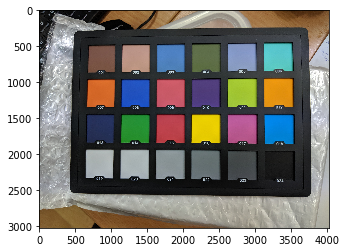

In [68]:
if __name__ == "__main__":
    
    colorChecker = cv2.imread('data/cc-china.jpg')
    cc = cv2.cvtColor(colorChecker,cv2.COLOR_BGR2RGB)
    plt.imshow(cc)

**Select ROIs from the Image**
- Select the color squares to extract the target RGB values
- Compute the mean for the B,G,R channels of each individual target ROI regions
- Swap the B,G,R to R,G,B
- Transform the sRGB values into linear RGB space

In [117]:
    #target = cv2.imread('experiment_data/CC1.jpg')
    target = cv2.imread('experiment_data/2.jpg')
    target = cv2.resize(target, (500,500),interpolation = cv2.INTER_AREA)
    
    ROIs = cv2.selectROIs('Select ROIs',target, fromCenter=False)
    targetValue = select_compute_meanRGB(target,ROIs)

    cv2.waitKey(0)    
    cv2.destroyAllWindows()

In [118]:
    #print(targetValue)
    targetValue = np.round(targetValue)
    
    #targetCIE = np.round(targetCIE)

    print(targetValue)
    
    ycolor = (183, 146, 1)
    targetColor = np.full((10,10,3),ycolor,dtype = np.uint8)
    
    targetHSV = cv2.cvtColor(targetColor, cv2.COLOR_RGB2HSV)
    print(targetHSV[0,0])
    #print(targetCIE)
    #targetValue_lab = cm.srgb_to_cielab(targetValue)
    #print(targetValue_lab)

[[158. 139.  60.]]
[ 24 254 183]


(250000, 3)


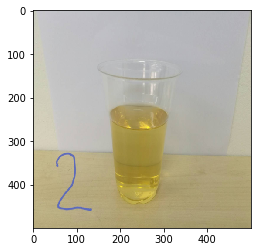

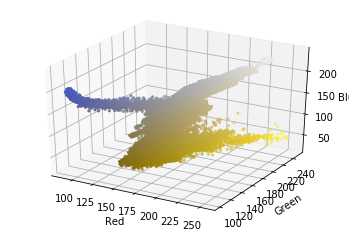

In [119]:
    targetRGB = cv2.cvtColor(target,cv2.COLOR_BGR2RGB)
    plt.imshow(targetRGB)
    r,g,b = cv2.split(targetRGB)
    fig = plt.figure()
    axis = fig.add_subplot(1,1,1,projection="3d")
    
    pixel_colors = targetRGB.reshape((np.shape(targetRGB)[0] * np.shape(targetRGB)[1],3))
    print(pixel_colors.shape)
    norm = colors.Normalize(vmin=-1.,vmax=1.)
    norm.autoscale(pixel_colors)
    pixel_colors = norm(pixel_colors).tolist()
    
    axis.scatter(r.flatten(),g.flatten(),b.flatten(), facecolors = pixel_colors,marker=".")
    axis.set_xlabel('Red')
    axis.set_ylabel('Green')
    axis.set_zlabel('Blue')
    plt.show()

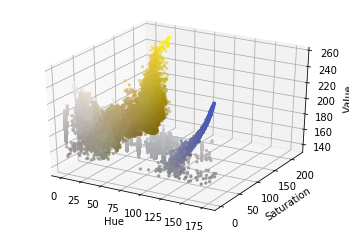

In [120]:
    hsv_urine = cv2.cvtColor(targetRGB, cv2.COLOR_RGB2HSV)
    
    h,s,v = cv2.split(hsv_urine)
    fig = plt.figure()
    axis = fig.add_subplot(1,1,1,projection="3d")
    
    axis.scatter(h.flatten(),s.flatten(), v.flatten(), facecolors = pixel_colors,marker=".")
    axis.set_xlabel('Hue')
    axis.set_ylabel('Saturation')
    axis.set_zlabel('Value')
    plt.show()

**Select the range of HSV Colors and Display**
- Light to Transparent yellows 
- Dark yellow to Dark brown
- Dark brown to red

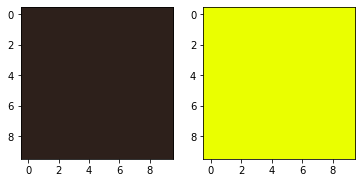

In [121]:
    #light_yellow = (45,40,200)
    light_yellow = (12, 100, 45)
    dark_yellow = (46,255,255)
    
    light_square = np.full((10,10,3),light_yellow,dtype = np.uint8) / 255.0
    dark_square = np.full((10,10,3),dark_yellow,dtype = np.uint8) / 255.0
    
    plt.subplot(1,2,1)
    plt.imshow(hsv_to_rgb(light_square))
    plt.subplot(1,2,2)
    plt.imshow(hsv_to_rgb(dark_square))
    plt.show()

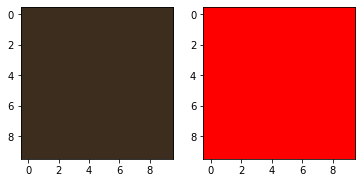

In [107]:
    #light_yellow = (45,40,200)
    light_orange = (20, 120, 60)
    dark_yellow = (255,255,255)
    
    light_orange = np.full((10,10,3),light_orange,dtype = np.uint8) / 255.0
    dark_square = np.full((10,10,3),dark_yellow,dtype = np.uint8) / 255.0
    
    plt.subplot(1,2,1)
    plt.imshow(hsv_to_rgb(light_orange))
    plt.subplot(1,2,2)
    plt.imshow(hsv_to_rgb(dark_square))
    plt.show()

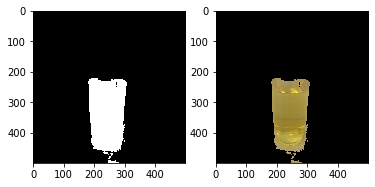

In [122]:
    mask = cv2.inRange(hsv_urine,light_yellow,dark_yellow)
    result = cv2.bitwise_and(targetRGB,targetRGB, mask=mask)
    view = cv2.cvtColor(result,cv2.COLOR_RGB2BGR)
    cv2.imshow("filtered view", view)
    
    plt.subplot(1,2,1)
    plt.imshow(mask,cmap="gray")
    plt.subplot(1,2,2)
    plt.imshow(result)
    plt.show()
    
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [74]:
    diff1 = cm.CIEDE2000((50, 2.6772, -79.7751), (50, 0.0000, -82.7485))
    
    print(diff1)
    #print(cm.CIEDE2000((50, 0, 0), (50.0000, -1, 2)))
    #print(cm.CIEDE2000((50, 2.5, 0), (73, 25, -18)))

TypeError: unsupported operand type(s) for -: 'float' and 'tuple'

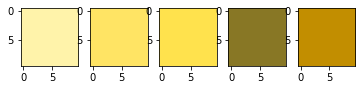

[[58.09450994 -2.69502892 43.87358048]]
[58.09450994 -2.69502892 43.87358048]
Code 1 26.95708295600349
[90.62768716 -5.33012415 64.2360585 ]
Code 2 24.67428619146861
[89.94680457 -5.62094907 72.80628564]
Code 3 24.851392548467125
[50.17014104 -3.04235281 45.28903411]
Code 4 7.621508469624043
[62.35143558  9.82411756 67.16649341]
Code 5 10.783175076416605


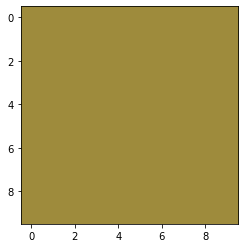

In [128]:
    #Define and draw the set standard of urine color code
    code1 = np.array([255,243,170])
    code2 =  np.array([255,228,100])
    code3 =  np.array([255,226,77])
    code4 =  np.array([136,119,37])
    code5 =  np.array([194,142,0])
    
    #print("Target RGB: ", targetValue)
    #target_CIE = cm.srgb_to_cielab(targetValue)
    #print(target_CIE)
    #target_CIE = target_CIE.tolist()
    #target_CIE = np.array([14.74001918,  8.83965167, 13.71097739])
    #print(target_CIE)
    
    code1_swatch = np.full((10,10,3),code1,dtype = np.uint8) / 255.0
    code2_swatch = np.full((10,10,3),code2,dtype = np.uint8) / 255.0
    code3_swatch = np.full((10,10,3),code3,dtype = np.uint8) / 255.0
    code4_swatch = np.full((10,10,3),code4,dtype = np.uint8) / 255.0
    code5_swatch = np.full((10,10,3),code5,dtype = np.uint8) / 255.0
    target_swatch = np.full((10,10,3),targetValue,dtype=np.uint8) / 255.0
        
    plt.subplot(1,5,1)
    plt.imshow(code1_swatch)
    plt.subplot(1,5,2)
    plt.imshow(code2_swatch)
    plt.subplot(1,5,3)
    plt.imshow(code3_swatch)
    plt.subplot(1,5,4)
    plt.imshow(code4_swatch)
    plt.subplot(1,5,5)
    plt.imshow(code5_swatch)
    plt.show()
    
    
    test1_swatchCIE = cm.srgb_to_cielab(targetValue)
    print(test1_swatchCIE)
    test1_swatchCIE = np.array([58.09450994, -2.69502892, 43.87358048])
    print(test1_swatchCIE)
    
    code1_swatchCIE = cm.srgb_to_cielab(code1)
    #print(code1_swatchCIE)
    
    #print(targetValue.shape)
    
    
    diff1 = CIEDE2000(code1_swatchCIE,test1_swatchCIE)
    print("Code 1",diff1)
    
    code2_swatchCIE = cm.srgb_to_cielab(code2)
    print(code2_swatchCIE)
    
    diff2 = CIEDE2000(code2_swatchCIE,test1_swatchCIE)
    print("Code 2",diff2)
    
    code3_swatchCIE = cm.srgb_to_cielab(code3)
    print(code3_swatchCIE)
    
    diff3 = CIEDE2000(code3_swatchCIE,test1_swatchCIE)
    print("Code 3",diff3)
    
    code4_swatchCIE = cm.srgb_to_cielab(code4)
    print(code4_swatchCIE)
    
    diff4 = CIEDE2000(code4_swatchCIE,test1_swatchCIE)
    print("Code 4",diff4)
    
    code5_swatchCIE = cm.srgb_to_cielab(code5)
    print(code5_swatchCIE)
    
    diff5 = CIEDE2000(code5_swatchCIE,test1_swatchCIE)
    print("Code 5",diff5)
    
    #test_diff = CIEDE2000(test1_swatchCIE, )
    
    code2_swatch = np.full((10,10,3),code2,dtype = np.uint8) / 255.0
    code3_swatch = np.full((10,10,3),code3,dtype = np.uint8) / 255.0
    code4_swatch = np.full((10,10,3),code4,dtype = np.uint8) / 255.0
    code5_swatch = np.full((10,10,3),code5,dtype = np.uint8) / 255.0
    
    plt.subplot(1,1,1)
    plt.imshow(target_swatch)
    plt.show()
    

**Computing the CCM using multiple regression**
- Normalize the reference values to convert from sRGB to linear sRGB space
- Compute the color correction matrix (CCM) using least squares method
- Multiply the CCM with the target values to get RGB values closer to the true colors
- Apply the CCM to the image to see the transformation

In [10]:
    linRefVal = cm.srgb_to_linsrgb(refRGB)
    linTargetVal = cm.srgb_to_linsrgb(targetValue)
    print(linRefVal.shape)
    print(linTargetVal.shape)
    
    #ColorCorrectionMatrix = np.linalg.lstsq(linTargetVal,linRefVal,rcond=None)[0]
    
    ColorCorrectionMatrix = cm.compute_ColorCorrectionMatrix(refRGB,targetValue)
    
    print('------ Color Correction Matrix--------\n')
    print(ColorCorrectionMatrix)
    print('--------------------------------------\n')

(24, 3)
(24, 3)
------ Color Correction Matrix--------

[[ 1.17906587 -0.05480988  0.0209311 ]
 [ 0.1988954   1.48659574  0.27580259]
 [ 0.106147   -0.01479907  0.91915885]]
--------------------------------------



In [13]:
    corrTargetVal = np.matmul(linTargetVal,ColorCorrectionMatrix)
    
    print("----------Corrected Target Value (Linear)----------------\n")
    print(corrTargetVal)
    print("---------------------------------------------------------\n")
    
    
    corrTargetVal = cm.linsrgb_to_srgb(corrTargetVal)
    print("----------Corrected Target Value (sRGB)----------------\n")
    print(corrTargetVal)
    print("---------------------------------------------------------\n")
    
       
    print("----------Corrected Target Value (sRGB)----------------\n")
    print(targetValue)
    print("---------------------------------------------------------\n")

----------Corrected Target Value (Linear)----------------

[[0.25508584 0.12353364 0.08862811]
 [0.67223786 0.41632102 0.30881889]
 [0.19173363 0.31417005 0.54551899]
 [0.17018893 0.2246943  0.10537187]
 [0.4096991  0.45882721 0.60644401]
 [0.29596342 0.83445413 0.69715954]
 [0.80850779 0.16990648 0.07112015]
 [0.08845472 0.11377134 0.5000195 ]
 [0.7258251  0.11840159 0.16670361]
 [0.12238031 0.05999653 0.19541546]
 [0.54865438 0.81887389 0.1953648 ]
 [0.97522366 0.38523376 0.09998147]
 [0.03805852 0.04147617 0.0979487 ]
 [0.0805868  0.41292646 0.10811799]
 [0.61331619 0.05278832 0.09116241]
 [1.08501638 0.86320741 0.18774664]
 [0.62500168 0.1214618  0.30505409]
 [0.12378321 0.32620592 0.74577594]
 [0.61086962 0.63325826 0.54042998]
 [0.60758273 0.64158772 0.55733914]
 [0.38602565 0.41553735 0.36601351]
 [0.20386493 0.2312504  0.20208344]
 [0.08629133 0.09227817 0.08028594]
 [0.0152958  0.01464821 0.01200204]]
---------------------------------------------------------

----------Correct

In [ ]:
    #print(targetCC)
    unCorrTarget = cc
    print(unCorrTarget.shape)
    dim = (800,700)
    targetCC1 = cv2.resize(unCorrTarget,dim,interpolation = cv2.INTER_AREA)
    print(targetCC1.shape)
    #targetImage = srgb_to_linsrgb(targetCC1)
    #ColorCorrectionMatrix = np.transpose(ColorCorrectionMatrix)
    newTargetImage = np.matmul(targetCC1,ColorCorrectionMatrix)
    print(newTargetImage.shape)
    print(newTargetImage[699,799,:])
    
    normalizelin = newTargetImage * 255.0
    linear2rgb = linsrgb_to_srgb(newTargetImage[699,799,:])
    print(linear2rgb)
    print(normalizelin)
    
    diffImg = targetCC1 - newTargetImage
    newImg = targetCC1 + diffImg
    cv2.imshow("correct image",normalizelin)
    plt.imshow(newTargetImage)

    cv2.waitKey(0)
    cv2.destroyAllWindows()

**Extract the Urine Color and Map it***
- Understand the range for yellow in RGB / HSV color space. e.g. RGB - (0-255,0-255,0-50) 
- Understand the change in opacity by moving the threshold from (255,255,0)
- Find the urine sample, by first thresholding and filtering for yellow color in the image